In [90]:
#install packages
#!pip install pytesseract, imutils

In [91]:
from imutils import contours
import numpy as np
import imutils
import cv2
from matplotlib import pyplot as plt
%matplotlib inline

image = cv2.imread("sample6_reshaped.jpg")
image_resized = imutils.resize(image, height = 400, width = 500)

gray=cv2.cvtColor(image_resized,cv2.COLOR_BGR2GRAY)

#gray_resized = imutils.resize(gray, width =500)

# gray = cv2.bitwise_not(gray)
# gray = cv2.GaussianBlur(gray,(5,5),0)

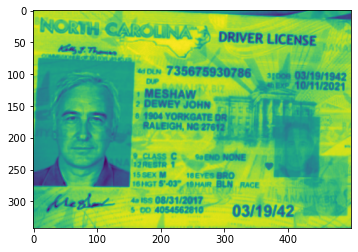

In [92]:
plt.imshow(gray)

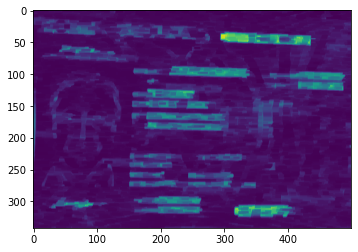

In [93]:
rectKernel = cv2.getStructuringElement(cv2.MORPH_RECT, (9, 3))

tophat = cv2.morphologyEx(gray,cv2.MORPH_TOPHAT,rectKernel)

# compute the Scharr gradient of the tophat image, then scale the rest back into the range [0, 255]
gradX = cv2.Sobel(tophat, ddepth=cv2.CV_64F, dx=1, dy=0,ksize=-1)

# gradX = cv2.Canny(tophat, 100, 200)

gradX = np.absolute(gradX)
(minVal, maxVal) = (np.min(gradX), np.max(gradX))
gradX = (255 * ((gradX - minVal) / (maxVal - minVal)))
gradX = gradX.astype("uint8")

gradX = cv2.morphologyEx(gradX, cv2.MORPH_CLOSE, rectKernel)
plt.imshow(gradX)

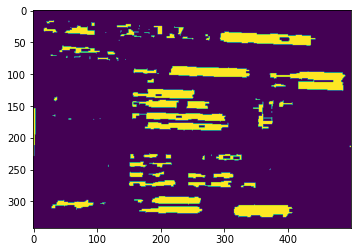

In [94]:
thresh = cv2.threshold(gradX, 127, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
 
sqKernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))

thresh = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, sqKernel)
plt.imshow(thresh)

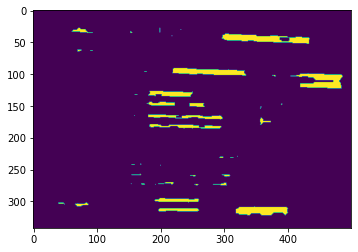

In [95]:
cnts, hierarchy = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

co1 = cv2.drawContours(thresh,cnts, -1, (0,255,0), 3)

plt.imshow(co1)

In [96]:
#edge = cv2.Canny(thresh, 127, 255)

los = []
rois_cnt = []
rois = []
rois_rect = []

for (i, c) in enumerate(cnts):
    (x,y,w,h) = cv2.boundingRect(c)
    
    ar = w/float(h) #ar > 1.2 and 
    if  ar > 2 and w > 5 and h > 5:
        los.append((x,y,w,h))
        #image_resized
        roi=gray[y-3:y+h+3, x-5: x+w+5]
        rois.append(roi)
        rois_rect.append((x-5,y-3,x+w+5,y+h+3))
        
        peri = cv2.arcLength(c, True)
        approx = cv2.approxPolyDP(c, 0.01*peri, True)
        rois_cnt.append(approx)
        
print(rois_rect)

[(162, 305, 271, 322), (311, 302, 413, 328), (24, 295, 100, 316), (154, 294, 178, 306), (182, 289, 269, 308), (322, 268, 355, 282), (239, 265, 317, 281), (146, 264, 229, 280), (239, 253, 276, 267), (279, 252, 320, 268), (147, 251, 178, 265), (177, 250, 211, 265), (178, 236, 223, 250), (147, 235, 184, 250), (283, 223, 333, 239), (169, 222, 201, 235), (171, 173, 312, 192), (151, 158, 308, 178), (236, 140, 282, 158), (382, 139, 413, 155), (151, 138, 234, 157), (152, 121, 259, 142), (370, 112, 402, 125), (367, 93, 496, 130), (153, 89, 199, 103), (209, 85, 346, 109), (36, 53, 110, 71), (289, 31, 449, 59), (132, 27, 175, 46), (12, 25, 43, 39), (45, 21, 102, 42), (127, 19, 159, 31)]


In [97]:
for i in range(len(rois)):
    im = cv2.resize(rois[i], None,fx=1, fy=1)    

ROIs = []
texts = []

for (startX, startY, endX, endY) in rois_rect:
	# scale the bounding box coordinates based on the respective ratios
	startX = int(startX )
	startY = int(startY)
	endX = int(endX)
	endY = int(endY)

	# draw the bounding box on the image
	cv2.rectangle(image_resized, (startX, startY), (endX, endY), (0, 255, 0), 2)

In [98]:
import unidecode, pytesseract
texts = []
for roi in rois:
           
    roi = cv2.resize(roi, None,fx=1, fy=1)
    kernel = np.array([[-1,-1,-1],[-1,9,-1],[-1,-1,-1]])
    roi = cv2.filter2D(roi,-1,kernel)
    
    kernel = np.ones((1,1))
    erosing = cv2.erode(roi, kernel, iterations = 2)
    opening = cv2.morphologyEx(erosing, cv2.MORPH_OPEN, kernel)
    
    closing = cv2.morphologyEx(opening, cv2.MORPH_CLOSE, kernel)
    retval, img = cv2.threshold(closing, 127, 255, cv2.THRESH_BINARY_INV)
    
    gau = cv2.bilateralFilter(img, 9, 75, 75)
    
    # for Chinese
#     config = ("-l eng --oem 1 --psm 7")
#     text = (pytesseract.image_to_string(roi, config = config)) #lang="chi_tra"))
    
    text = pytesseract.image_to_string(gau, lang = 'eng')
    text = text.replace('\n\x0c', "")
    texts.append(text)
print(texts)

['D 4054562810', '\x0c', '\x0c', 'Lo', ' ', '\x0c', '[0 =9', " \n\n16 11GT 5'-0)\n\n ", '18EYE', ' ', 'REE', 'EX M', 'ESTR 1', 'R', '\x0c', 'CLAS', ' ', ' ', '\x0c', ' ', ' ', ' ', ' ', 'syoon 03/19/1942\nARt', "Ll +'a)", 'RGTY £ kY41', 'A T,', 'DRIVER LICENSE', '«', '\x0c', ' ', '\x0c']
